### Projeto Módulo 13 - Análise de sentimento no Twitter

https://www.kaggle.com/code/akshayarajasekaran/cd-sentiment-analysis-of-tweets/notebook

O dataset contém 1_600_000 tweets extraido pelo Twitter API. É classificado por gradação (0: Negativo e 4: Positivo) uqe podem ser usados para detectar sentimentos.
Contém 6 campos:
- sentiment : polarização do tweet (0= negativo a 4=positivo)
- ids
- date : data no formato (Sat May 16 23:58:44 UTC 2009)
- flag : The query
- user : usuário
- text : texto do tweet

É necessário apenas a análise do text

----

### Pré-análise e configuração do dataset

In [10]:
import pandas as pd
import numpy as np

In [7]:
path = "../../twitter_proj/training.1600000.processed.noemoticon.csv"
dataset = pd.read_csv(path, names = ["label", "ids", "date", "flag", "user", "tweet"])

In [8]:
# O que tem no dataset
dataset.head()

,label,ids,date,flag,user,tweet
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [9]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   label   1600000 non-null  int64 
 1   ids     1600000 non-null  int64 
 2   date    1600000 non-null  object
 3   flag    1600000 non-null  object
 4   user    1600000 non-null  object
 5   tweet   1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [10]:
# Substituir o 'label' 4 (positivo) para 1
dataset["label"].replace(4, 1, inplace = True)

In [11]:
# Ver balanceamento de labels
dataset["label"].value_counts(normalize = True)

0    0.5
1    0.5
Name: label, dtype: float64

A amostra está balanceada. Não há problema em utilizar a **acurácia** para avaliar a classificação

Podemos dropar o Id, date (não precisamos avaliar em qual o momento foi twitado), flag (só tem um valor) e user (não precisamos saber quem disse). Além disso, não temos valores nulos.

In [12]:
dataset.drop(["ids","date","flag","user"], axis = 1, inplace = True)

In [13]:
# Quantas letras tem cada tweet?
dataset["caracteres"] = dataset["tweet"].apply(lambda x: len(x))

In [14]:
dataset.head()

,label,tweet,caracteres
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",115
1,0,is upset that he can't update his Facebook by ...,111
2,0,@Kenichan I dived many times for the ball. Man...,89
3,0,my whole body feels itchy and like its on fire,47
4,0,"@nationwideclass no, it's not behaving at all....",111


----

### Pré-processamento do dataset

In [15]:
# Preprocessamento

# Bibliotecas
import pandas as pd
from nltk.tokenize import word_tokenize  # tokenização
from nltk.stem import *  # importar PorterStemmer() e WordNetLemmatizer()
from nltk.corpus import stopwords  # Stopwords
import nltk  # para baixar os 'stopwords' e 'punkt' (punctuation)
import re  # regex

nltk.download('stopwords')
nltk.download('punkt')
# Define as stopwords em inglês
sw_english = set(stopwords.words('english'))

# Instancia o PorterStemmer e WordNetLemmatizer
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

# Função de preprocessamento - 
def preprocessing(string, method = 'stem'):
    """
    Preprocessing for english
    """
    # Manter somente caracteres e números - sem caracteres especiais
    string = re.sub(r"[^a-zA-Z0-9]+", " ", string)
    # Letras minúsculas
    string = string.lower()
    # tokenização
    words = word_tokenize(string)
    
    filter_words = [word for word in words if word not in sw_english]
    words = []
    
    if method == 'stem':
        for word in filter_words:
            sw = stemmer.stem(word)
            words.append(sw)
        return words
    if method == 'lemma':
        for word in filter_words:
            sw = lemmatizer.lemmatize(word)
            words.append(sw)
        return words
    
# use dataframe['nova_col'].apply(lambda x: preprocessing(x, "stem")) para criar uma nova coluna no dataframe

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\gabri\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\gabri\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [16]:
# Criando novas colunas no dataset para ML
dataset['filtered_words'] = dataset["tweet"].apply(lambda x: preprocessing(x, "lemma"))
dataset['joined_words'] = dataset["filtered_words"].apply(lambda x: " ".join(x))

In [17]:
dataset.shape

(1600000, 5)

# Salvar dataset pré-processado
path = "../../twitter_proj/dataset_twitter.csv"
dataset.to_csv(path)

----

### Palavras mais frequentes

In [12]:
import matplotlib.pyplot as plt
from nltk.probability import FreqDist

In [48]:
twitter_words = []
for i in range(len(dataset)):
    twitter_words += dataset.iloc[i]["filtered_words"]   

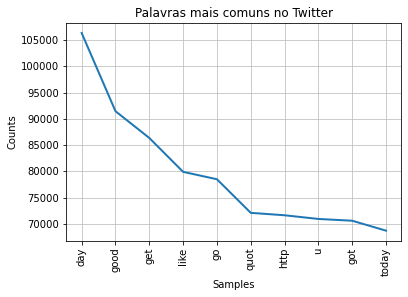

In [49]:
fdist = FreqDist(twitter_words)
fdist.plot(10, title = "Palavras mais comuns no Twitter")
plt.show()

Nota-se que são palavras relativamente neutras.

### Analisando as palavras mais comuns em tweets com sentimentos positivos e negativos

In [14]:
# Tweets com sentimentos positivos (1)
twitter_words_pos = dataset[dataset["label"] == 1]
# Tweets com sentimentos negativos (0)
twitter_words_neg = dataset[dataset["label"] == 0]

In [16]:
words_tweet_1 = []
for i in range(len(twitter_words_pos["filtered_words"])):
    words_tweet_1 += twitter_words_pos.iloc[i]["filtered_words"]    

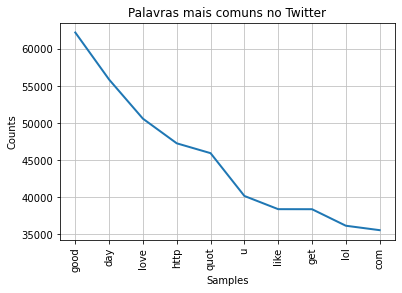

In [17]:
fdist = FreqDist(words_tweet_1)
fdist.plot(10, title = "Palavras mais comuns no Twitter com sentimentos positivos")
plt.show()

In [18]:
words_tweet_0 = []
for i in range(len(twitter_words_neg["filtered_words"])):
    words_tweet_0 += twitter_words_neg.iloc[i]["filtered_words"]

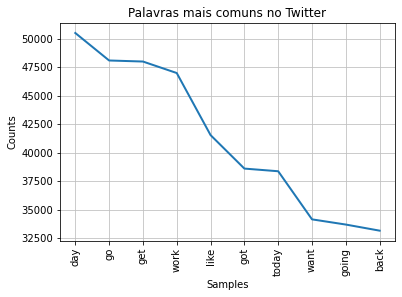

In [19]:
fdist = FreqDist(words_tweet_0)
fdist.plot(10, title = "Palavras mais comuns no Twitter com sentimentos negativos")
plt.show()

- Palavras relacionadas à sentimentos positivos: "good", "love", "like", "lol".
- Palavras relacionadas à sentimentos negativos: "get", "work", "want", "going", "back"

---

#### Dataset já pré-processado, tirado uma amostra de 10% e com NaNs dropados

In [2]:
# Dataset pré-processado
path = "../../twitter_proj/dataset_twitter.csv"
dataset = pd.read_csv(path)

In [3]:
# Como a amostra é muitp grande e fazer GridSearch é impensável, toma-se uma amostra de 10%
twitter_sample = dataset.sample(frac = 0.1, replace=False)

In [20]:
twitter_sample.dropna(inplace = True)

In [21]:
twitter_sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159956 entries, 401870 to 1451442
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   Unnamed: 0      159956 non-null  int64 
 1   label           159956 non-null  int64 
 2   tweet           159956 non-null  object
 3   caracteres      159956 non-null  int64 
 4   filtered_words  159956 non-null  object
 5   joined_words    159956 non-null  object
dtypes: int64(3), object(3)
memory usage: 8.5+ MB


## Modelos de Machine Learning

In [22]:
# Separar amostras de treino e teste
from sklearn.model_selection import train_test_split

X = twitter_sample["joined_words"]
y = twitter_sample["label"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [69]:
# Bibliotecas e modelos
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline

# Processamentos
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA

# Usar os modelos abaixo
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

### Baseline com LogisticRegression (sem otimização de hiperparâmetros)

In [24]:
# Vetorização e modelo de ML
text_model_lr = Pipeline([
    ("tfidf", TfidfVectorizer()),
    ("model", LogisticRegression())
])

text_model_lr

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('model', LogisticRegression())])

In [25]:
text_model_lr.fit(X_train, y_train)
predictions_lr = text_model_lr.predict(X_test)

C:\Users\gabri\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [26]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_curve, roc_auc_score

print(confusion_matrix(y_test, predictions_lr))
print()
print(classification_report(y_test, predictions_lr))
print()
print(f"A acurácia é {accuracy_score(y_test, predictions_lr)}")

[[18179  5970]
 [ 5277 18561]]

              precision    recall  f1-score   support

           0       0.78      0.75      0.76     24149
           1       0.76      0.78      0.77     23838

    accuracy                           0.77     47987
   macro avg       0.77      0.77      0.77     47987
weighted avg       0.77      0.77      0.77     47987


A acurácia é 0.7656240231729426


### LogisticRegression com tunning de Hiperparâmetros

In [35]:
# Vetorização e modelo de ML
text_model_lrh = Pipeline([
    ("tfidf", TfidfVectorizer()),
    ("model", LogisticRegression())
])

# param_grid
param_grid={'model__penalty': ['l1', 'l2'],
            'model__solver': ['liblinear']}

# GridSearch
fold = StratifiedKFold(n_splits = 3, shuffle = True, random_state = 42)
grid_lr = GridSearchCV(text_model_lrh, param_grid = param_grid, cv = fold, scoring = 'neg_mean_absolute_error', return_train_score = True)

In [36]:
grid_lr.fit(X_train, y_train)
predictions = grid_lr.predict(X_test)

In [37]:
# Melhores parâmetros
print(grid_lr.best_params_)

{'model__penalty': 'l2', 'model__solver': 'liblinear'}


In [38]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_curve, roc_auc_score

print(confusion_matrix(y_test, predictions))
print()
print(classification_report(y_test, predictions))
print()
print(f"A acurácia é {accuracy_score(y_test, predictions)}")

[[18190  5959]
 [ 5280 18558]]

              precision    recall  f1-score   support

           0       0.78      0.75      0.76     24149
           1       0.76      0.78      0.77     23838

    accuracy                           0.77     47987
   macro avg       0.77      0.77      0.77     47987
weighted avg       0.77      0.77      0.77     47987


A acurácia é 0.7657907349907267


Não houve muita mudança com tunning de hiperparâmetros

### RandomForest

In [43]:
# Modelo RandomForest
text_model_rf = Pipeline([
            ('tfidf', TfidfVectorizer()),
            ('model', RandomForestClassifier())
])

text_model_rf

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('model', RandomForestClassifier())])

In [44]:
grid_rf.fit(X_train, y_train)
predictions = grid_rf.predict(X_test)

In [45]:
# Melhores parâmetros
print(grid_rf.best_params_)

{'model__criterion': 'gini', 'model__max_depth': 20}


In [46]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_curve, roc_auc_score

print(confusion_matrix(y_test, predictions))
print()
print(classification_report(y_test, predictions))
print()
print(f"A acurácia é {accuracy_score(y_test, predictions)}")

[[17346  6803]
 [ 6397 17441]]

              precision    recall  f1-score   support

           0       0.73      0.72      0.72     24149
           1       0.72      0.73      0.73     23838

    accuracy                           0.72     47987
   macro avg       0.72      0.72      0.72     47987
weighted avg       0.73      0.72      0.72     47987


A acurácia é 0.7249255006564278


A acurácia ficou menor que em LogisticRegression

### RandomForest com tunning de hiperparâmetros

In [39]:
# Modelo RandomForest
text_model_rfh = Pipeline([
            ('tfidf', TfidfVectorizer()),
            ('model', RandomForestClassifier())
])

# Param_grid
param_grid={'model__max_depth': [10, 15, 20],
            'model__criterion': ['entropy', 'gini']}

# GridSearch
fold = StratifiedKFold(n_splits = 3, shuffle = True, random_state = 42)
grid_rf = GridSearchCV(text_model_rfh, param_grid = param_grid, cv = fold, scoring = 'neg_mean_absolute_error', return_train_score = True)

In [40]:
grid_rfh.fit(X_train, y_train)
predictions = grid_rfh.predict(X_test)

In [41]:
# Melhores parâmetros
print(grid_rfh.best_params_)

{'model__criterion': 'gini', 'model__max_depth': 20}


In [42]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_curve, roc_auc_score

print(confusion_matrix(y_test, predictions))
print()
print(classification_report(y_test, predictions))
print()
print(f"A acurácia é {accuracy_score(y_test, predictions)}")

[[17103  7046]
 [ 5974 17864]]

              precision    recall  f1-score   support

           0       0.74      0.71      0.72     24149
           1       0.72      0.75      0.73     23838

    accuracy                           0.73     47987
   macro avg       0.73      0.73      0.73     47987
weighted avg       0.73      0.73      0.73     47987


A acurácia é 0.7286765165565674


Melhorou muito pouco com o tunning

### RandomForest com PCA

In [50]:
# Modelo com SVD
text_model_rfsvd = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ("sc", StandardScaler(with_mean=False)),
    ("svd", TruncatedSVD(n_components = 10, random_state = 42)),
    ('rf', RandomForestClassifier())
])

text_model_rfsvd

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('sc', StandardScaler(with_mean=False)),
                ('svd', TruncatedSVD(n_components=10, random_state=42)),
                ('rf', RandomForestClassifier())])

In [51]:
text_model_rfsvd.fit(X_train, y_train)
predictions = text_model_rfsvd.predict(X_test)

In [53]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_curve, roc_auc_score

print(confusion_matrix(y_test, predictions))
print()
print(classification_report(y_test, predictions))
print()
print(f"A acurácia é {accuracy_score(y_test, predictions)}")

[[14704  9445]
 [11674 12164]]

              precision    recall  f1-score   support

           0       0.56      0.61      0.58     24149
           1       0.56      0.51      0.54     23838

    accuracy                           0.56     47987
   macro avg       0.56      0.56      0.56     47987
weighted avg       0.56      0.56      0.56     47987


A acurácia é 0.5599016400275074


: (

### Linear SVC

In [65]:
text_model_svc = Pipeline([
    ("tfidf", TfidfVectorizer()),
    ("model", LinearSVC())
])

param_grid={
            'model__C': [1.0, 10.0, 100.0]}

# GridSearch
fold = StratifiedKFold(n_splits = 3, shuffle = True, random_state = 42)
grid_svc = GridSearchCV(text_model_svc, param_grid = param_grid, cv = fold, scoring = 'neg_mean_absolute_error', return_train_score = True)

In [67]:
grid_svc.fit(X_train, y_train)
predictions = grid_svc.predict(X_test)

C:\Users\gabri\Anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\gabri\Anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\gabri\Anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [68]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_curve, roc_auc_score

print(confusion_matrix(y_test, predictions))
print()
print(classification_report(y_test, predictions))
print()
print(f"A acurácia é {accuracy_score(y_test, predictions)}")

[[18121  6028]
 [ 5767 18071]]

              precision    recall  f1-score   support

           0       0.76      0.75      0.75     24149
           1       0.75      0.76      0.75     23838

    accuracy                           0.75     47987
   macro avg       0.75      0.75      0.75     47987
weighted avg       0.75      0.75      0.75     47987


A acurácia é 0.7542042636547398


Um pouco abaixo de LogisticRegression

### XGBoost

In [70]:
text_model_xgb = Pipeline([
    ("tfidf", TfidfVectorizer()),
    ("model", XGBClassifier(learning_rate = 0.1, eval_metric = "logloss"))
])

text_model_xgb

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('model',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, eval_metric='logloss',
                               gamma=None, gpu_id=None, importance_type='gain',
                               interaction_constraints=None, learning_rate=0.1,
                               max_delta_step=None, max_depth=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               random_state=None, reg_alpha=None,
                               reg_lambda=None, scale_pos_weight=None,
                               subsample=None, tree_method=None,
                               validate_parameters=None, verbosity=Non

In [71]:
text_model_xgb.fit(X_train, y_train)
predictions = text_model_xgb.predict(X_test)

C:\Users\gabri\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


In [74]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_curve, roc_auc_score

print(confusion_matrix(y_test, predictions))
print()
print(classification_report(y_test, predictions))
print()
print(f"A acurácia é {accuracy_score(y_test, predictions)}")

[[13580 10569]
 [ 3853 19985]]

              precision    recall  f1-score   support

           0       0.78      0.56      0.65     24149
           1       0.65      0.84      0.73     23838

    accuracy                           0.70     47987
   macro avg       0.72      0.70      0.69     47987
weighted avg       0.72      0.70      0.69     47987


A acurácia é 0.6994602704899243


Menos de 70%

----

#### LogisticRegression com GridSearch teve maior acurácia, 76%

----